In [4]:
!pip install --user numpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

print(tf.__version__) # verifica veloce versione TF

2.13.0


In [7]:
# Carica CIFAR-10: (X_train, y_train), (X_test, y_test)
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10. load_data()
y_train_full = y_train_full. flatten()
y_test_full = y_test_full. flatten()

# CIFAR-10 label map ufficiale
label_names = ['airplane', 'automobile' , 'bird' , 'cat' , 'deer' , 'dog' , ' frog' , 'horse' , 'ship' , 'truck' ]
cat_label, dog_label = 3, 5

# Filtra solo gatti e cani
train_mask = (y_train_full == cat_label) | (y_train_full == dog_label)
test_mask = (y_test_full == cat_label) | (y_test_full == dog_label)

X_train_cd = X_train_full[train_mask]
y_train_cd = y_train_full[train_mask]
X_test_cd = X_test_full[test_mask]
y_test_cd = y_test_full[test_mask]

# Rimappa etichette: cat->0, dog->1
y_train_cd = (y_train_cd == dog_label).astype(np.int32)
y_test_cd =(y_test_cd == dog_label).astype(np.int32)

X_train_cd. shape, X_test_cd.shape, np.bincount(y_train_cd), np.bincount(y_test_cd)

170498071/170498071 [==============================] - 8s 0us/step


((10000, 32, 32, 3),
 (2000, 32, 32, 3),
 array([5000, 5000], dtype=int64),
 array([1000, 1000], dtype=int64))

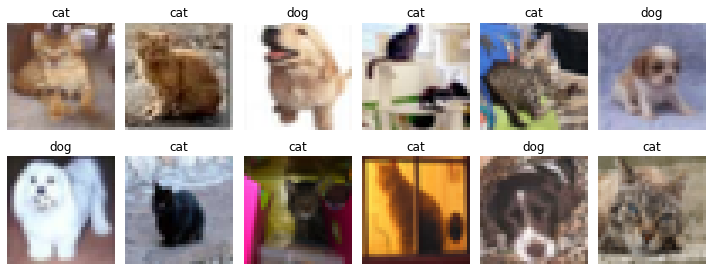

In [9]:
# Mostra alcune immagini (cat/dog) con titolo
def show_examples(X, y, class_names=('cat','dog'), n=12):
    plt.figure(figsize=(10, 4))
    idx = np.random.choice(len(X), size=n, replace=False)
    for i, j in enumerate(idx):
        plt.subplot(2, n//2, i+1)
        plt.imshow(X[j])
        plt.title(class_names[y[j]])
        plt.axis('off')
    plt.tight_layout ()
    plt.show()

show_examples(X_train_cd, y_train_cd, n=12)

In [17]:
# Opzione: riduci il numero di campioni per velocizzare il training in aula
# Imposta a None per usare tutti i dati disponibili
SAMPLES_PER_CLASS_TRAIN = 6000 # es: 3000 cat + 3000 dog = 6000
SAMPLES_PER_CLASS_TEST = 500

def subsample_balanced(X, y, samples_per_class) :
    if samples_per_class is None:
        return X, y
    X_out, y_out = [], []
    for cls in [0,1]:
        idx = np.where(y == cls) [0]
        idx = np. random. choice(idx, size=min(samples_per_class, len(idx)), replace=False)
        X_out.append(X[idx])
        y_out.append(y[idx])
    return np.concatenate(X_out), np.concatenate(y_out)

X_train_small, y_train_small = subsample_balanced(X_train_cd, y_train_cd, SAMPLES_PER_CLASS_TRAIN)
X_test_small, y_test_small = subsample_balanced(X_test_cd, y_test_cd, SAMPLES_PER_CLASS_TEST)

# Mescola il training
perm = np. random.permutation(len(X_train_small) )
X_train_small, y_train_small = X_train_small[perm], y_train_small[perm]

# Normalizzazione [0,1]
X_train_small = X_train_small.astype('float32') / 255.0
X_test_small = X_test_small.astype('float32') / 255.0

X_train_small.shape, X_test_small.shape

((10000, 32, 32, 3), (1000, 32, 32, 3))

In [18]:
def build_cnn(input_shape=(32,32,3)):
    model = models. Sequential( [
        layers. Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128,(3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers. Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid') # output binario
    ])
    model. compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn()
model. summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 128)        

In [22]:
EPOCHS = 18
history = model. fit(
    X_train_small, y_train_small,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=64,
    verbose=1
)

Epoch 1/18
141/141 [==============================] - 8s 56ms/step - loss: 0.0625 - accuracy: 0.9784 - val_loss: 0.9695 - val_accuracy: 0.7550
Epoch 2/18
141/141 [==============================] - 8s 57ms/step - loss: 0.0371 - accuracy: 0.9888 - val_loss: 1.0812 - val_accuracy: 0.7590
Epoch 3/18
141/141 [==============================] - 8s 54ms/step - loss: 0.0230 - accuracy: 0.9950 - val_loss: 1.2846 - val_accuracy: 0.7330
Epoch 4/18
141/141 [==============================] - 8s 55ms/step - loss: 0.0296 - accuracy: 0.9901 - val_loss: 1.2723 - val_accuracy: 0.7520
Epoch 5/18
141/141 [==============================] - 8s 56ms/step - loss: 0.0612 - accuracy: 0.9760 - val_loss: 1.5078 - val_accuracy: 0.7220
Epoch 6/18
141/141 [==============================] - 8s 56ms/step - loss: 0.0580 - accuracy: 0.9776 - val_loss: 1.3931 - val_accuracy: 0.7490
Epoch 7/18
141/141 [==============================] - 8s 55ms/step - loss: 0.0337 - accuracy: 0.9881 - val_loss: 1.3428 - val_accuracy: 0.7480

In [23]:
# Valutazione su test
y_prob = model. predict(X_test_small) . ravel()
y_pred = (y_prob >=0.5).astype(int)

acc = accuracy_score(y_test_small, y_pred)
cm = confusion_matrix(y_test_small, y_pred)

print(f"Accuracy test: {acc :.3f}")
print("Confusion Matrix (rows=veri, cols=predetti):\n", cm)
print("\nReport:\n", classification_report(y_test_small, y_pred, target_names=['cat', 'dog' ] ) )

32/32 [==============================] - 0s 8ms/step
Accuracy test: 0.781
Confusion Matrix (rows=veri, cols=predetti):
 [[389 111]
 [108 392]]

Report:
               precision    recall  f1-score   support

         cat       0.78      0.78      0.78       500
         dog       0.78      0.78      0.78       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



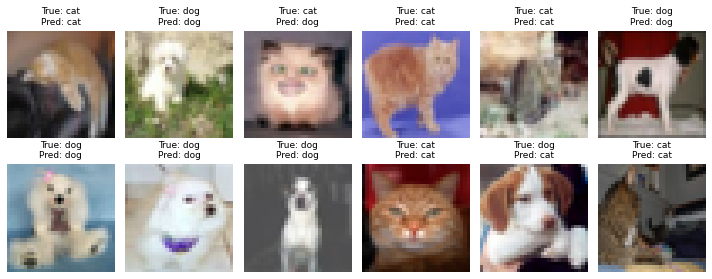

In [27]:
def show_predictions(X, y_true, y_hat, n=12):
    plt.figure(figsize=(10, 4))
    idx = np.random. choice(len(X), size=n, replace=False)
    for i, j in enumerate(idx):
        plt.subplot(2, n//2, i+1)
        plt.imshow(X[j])
        title = f"True: {'dog' if y_true[j] == 1 else 'cat' }\nPred: {'dog' if y_hat[j] == 1 else 'cat'}"
        plt.title(title, fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Attenzione: X_test_small era normalizzato (float in [0,1]), per visualizzare manteniamo così
show_predictions(X_test_small, y_test_small, y_pred, n=12)